In [ ]:
%matplotlib inline
import torch
import numpy as np
import timeit
import matplotlib.pyplot as plt
import matplotlib

## What will we be doing

1. Learn 3 techniques to solve ODEs
2. Program them
3. Plot them

This time we will be using PyTorch so you'll have a chance to experience the package.

# The forward Euler method

We assume a general nonlinear system of Ordinary Differential Equations of the form
$$ \dot{\bf y} = f({\bf y},t) \quad \quad {\bf y}(0) = {\bf y})_0. $$

Using a simple finite difference approximation to the derivative we obtain
$$ {\frac {{\bf y}_{j+1} - {\bf y}_j}{h}}  = f({\bf y}_j,t_j) + {\cal O}(h) $$

Yielding the approximation
$$ {\bf y}_{j+1} = {\bf y}_j  + hf({\bf y}_j,t_j) $$


The forward Euler method can be easily coded 

In [ ]:
def forwardEuler(f,h,n,y0):
    
    k = y0.shape[0]
    Y = torch.zeros(k,n+1)
    Y[:,0] = y0
    
    t = 0.0
    for j in range(n):
        Y[:,j+1] = Y[:,j] + h*f(Y[:,j],t) 
        t += h

    return Y

Let us test the code

In [ ]:
# Define our own function
def yfun(y,t):
    return -y

In [ ]:
h = 0.01
n = 1000
y0 = torch.ones(2); y0[1] = -1.0
Y = forwardEuler(yfun,h,n,y0)

The analytic solution is $\exp(-t)$ so this looks good. 

Text(0.5,1,'Error in the Numerical vs analytical solution')

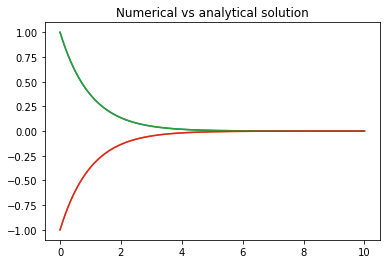

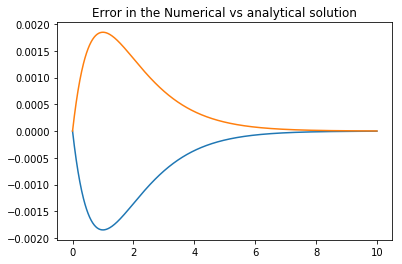

In [ ]:
t = np.arange(0,n+1)*h
# The solutions 
plt.figure(1)
plt.plot(t,Y[0,:],t,Y[1,:], t, np.exp(-t),t, -np.exp(-t));
plt.title('Numerical vs analytical solution')
# The error
plt.figure(2)
plt.plot(t,Y[0,:].numpy()-np.exp(-t),t,Y[1,:].numpy()+np.exp(-t));
plt.title('Error in the Numerical vs analytical solution')




But let us run this again with a few choices of step size $h$.

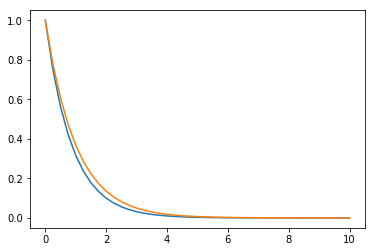

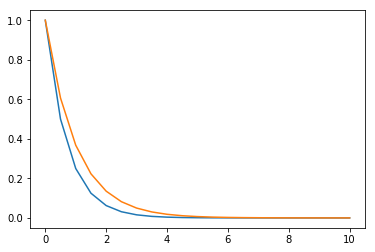

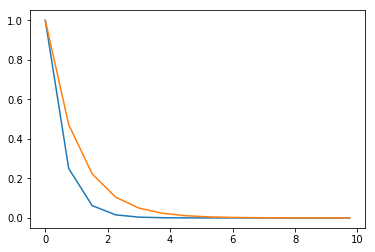

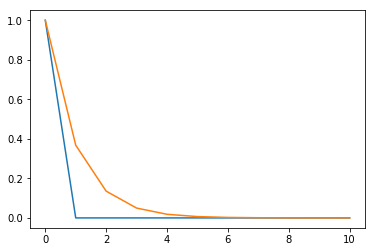

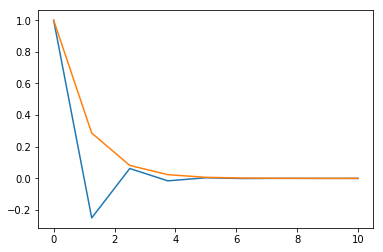

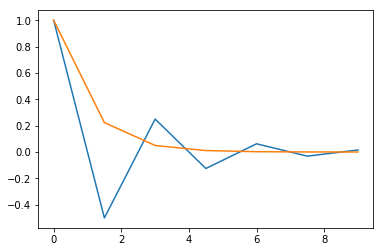

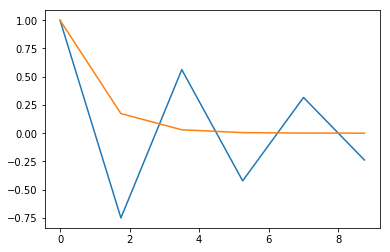

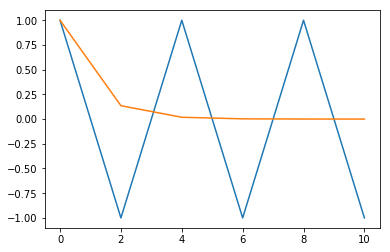

In [ ]:
for i in range(8):
    h = 0.25*(i+1)
    n = np.int(10/h)
    y0 = torch.ones(2); y0[1] = -1.0
    Y = forwardEuler(yfun,h,n,y0)
    t = np.arange(0,n+1)*h
    plt.figure(i+1)
    plt.plot(t,Y[0,:],t,np.exp(-t))

The solution starts reasonable but then it simply deviates from the analytic solution and starts to diverge. The question is why and how can we fix it.

# Stability of the solution

Using a numerical method to solve an ODE does not always guarantees reasonable results. Maybe the obvious problem is stability of the solution.

Consider the simplest case of the ODE
$$ \dot{y} = \lambda y $$
and assume that $Re(\lambda) \le 0$. The solution of this problem is non-increasing.

Now consider the forward Euler solution to this problem that reads
$$ y_{j+1} = (1 + h \lambda) y_j. $$.
Since the continuous ODE is non-increasing we need to have the
solution of the discrete ODE to be non-increasing as well.
This can happen only if
$$ | 1 + h \lambda | \le 1. $$ 

Remember that $\lambda$ is a complex number $\lambda = \lambda_r + i \lambda_i$ and the condition above implies that
$$ (1 + h\lambda_r)^2 + h^2\lambda_i^2 \le 1 $$
Reorganizing we obtain that
$$ h(\lambda_r^2 + \lambda_i^2) = h|\lambda |^2  \le -2\lambda_r. $$


If $Re(\lambda) < 0$ then this condition tells us that $h$ needs to be small enough. However, note that if $\lambda$ is purely imaginary then there is {\bf no step} that yields a non-increasing solution and the forward Euler method fails.


# The backward Euler and the trapezoidal methods

To deal with the stability issue of the forward Euler it is possible to use a different discretization.
To this end we use a different approximation to the derivative in order to obtain a stable method

The backward Euler method uses the backward difference formula. in order to
approximate the ODE
\begin{eqnarray}
{\bf y}_{j+1} - {\bf y}_j = h f({\bf y}_{j+1},t_{j+1})
\end{eqnarray}

This is an {\bf implicit} method. The function $\bf y_{j+1}$ at times $t_{j+1}$ needs to
be solved from the equation. This, in many cases cannot be done analytically
and numerical methods need to be used to solve the problem.
Given this added complexity one may ask, why do we need such a technique?

A quick repeat of the stability analysis above yields that the method is unconditionaly stable.


The trapezoidal method use the trapezoidal method of integration to obtain
\begin{eqnarray}
{\bf y}_{j+1} - {\bf y}_j = {\frac h2}\left( f({\bf y}_{j+1},t_{j+1}) + f({\bf y}_{j},t_{j})\right)
\end{eqnarray}

This is an implicit method as well. However, it is second order and has some nice properties that we will resolve next.


# Class assignment
Use the same analysis we have done for the forward Euler method to show that the backward Euler method and the trapezoidal methods are unconditionally stable.

# Using Implicit Methods to solve a linear system of ODEs

Coding an implicit ODE solver require us to solve a nonlinear system of equations and therefore requires more numerics than we have now. However, for linear systems it is possible to use implicit methods and to write efficient codes for that.

To this end assume that
$$ \dot {\bf y} = {\bf A}(t) {\bf y} + f(t)$$
The backward Euler method for this problem reads
$$  \left({\bf I} - h {\bf A}(t_{j+1}) \right) {\bf y}_{j+1} = {\bf y}_{j} + hf(t_{j+1}) $$

Solving the system we obtain
$$  {\bf y}_{j+1} = \left({\bf I} - h {\bf A}(t_{j+1}) \right)^{-1}  \left( {\bf y}_{j} + hf(t_{j+1}) \right) $$




# Quick review - solving linear systems

Solving linear systems is one of the cornerstones of scientific computing and it appears in numerous applications in science and engineering. In general, the goal is to find a vector ${\bf x}$ that solves the linear system
$$ {\bf A} {\bf x} = {\bf b} $$

For example, the solution of the system 
$$ \begin{pmatrix} -2 & 1 \\ 1 & -2 \end{pmatrix}
\begin{pmatrix} {\bf x}_1 \\ {\bf x}_2 \end{pmatrix} = 
\begin{pmatrix} 1 \\ 2 \end{pmatrix} $$
is ${\bf x} = -[\frac 43, \frac 53]$.

There are a number of methods to solve linear systems. Commonly the matrix ${\bf A}$ is decomposed into a lower trangular
and an upper triangular systems
$$ {\bf A} = {\bf L}{\bf U}. $$

For the example above
$$ \begin{pmatrix} -2 & 1 \\ 1 & -2 \end{pmatrix} =
\begin{pmatrix} 1 & 0 \\ -0.5 & 1 \end{pmatrix} \begin{pmatrix} -2 & 1 \\ 0 & -1.5 \end{pmatrix} $$

We can then solve the system by forward/backward substitutions
$$ {\bf A}{\bf x} = {\bf L}{\bf U}{\bf x} ={\bf b} $$
Then, solve (by forward substitution)
$$  {\bf L}{\bf z} ={\bf b}  \quad {\rm where} \quad {\bf z} = {\bf U}{\bf x}$$
and finally solve (by backward substitution
$$  {\bf U}{\bf x} = {\bf z} $$ 

It is important to remember that not all linear systems are solvable. For example, the system
$$ \begin{pmatrix} 1 & 1 \\ 1 & 1 \end{pmatrix}
\begin{pmatrix} {\bf x}_1 \\ {\bf x}_2 \end{pmatrix} = 
\begin{pmatrix} 1 \\ 2 \end{pmatrix} $$
Has no solution (why?)

Similarly, the linear system
$$ \begin{pmatrix} 1 & 1 \\ 1 & 1+\epsilon \end{pmatrix}
\begin{pmatrix} {\bf x}_1 \\ {\bf x}_2 \end{pmatrix} = 
\begin{pmatrix} 1 \\ 2 \end{pmatrix} $$
has a solution, but as $\epsilon \rightarrow 0$ the solution becomes unstable and in finite precision cannot be obtained
in any reliable way. This is often refers to as ill-conditioning.

Most scientific software packages has implemented some solver for systems of equations. In PyTorch this is done by the command solve, demonstrated below. 


In [ ]:
n = 5 # The size of the linear system
A = torch.randn(n) + torch.eye(n)
b = torch.randn(n)
b = b.unsqueeze(1) # note - solve expects a matrix for b
x, LU = torch.solve(b,A)  

# Check accuracy
r = torch.matmul(A,x) - b
err = torch.norm(r)/torch.norm(b)
print(n,err.item())


5 1.6043166795043362e-07


# Class assignment
Modify the code above and change  $n= 2^j, \ j=2,\ldots,12$ and plot the error as a function of $j$. What do you observe?


In [ ]:
for j in range(2,13):
    n = 2**j
    ## Your code
    
# plt.plot ...    


# Back to the backward Euler method
We now return to the backward Euler method. Using the solution of the linear systems we can now easily program the backward Euler method as

In [ ]:
def backEuler(y0,fun,Afun,h,n):
    k = y0.shape[0]
    Y = torch.zeros(k,n+1)
    Y[:,0] = y0
    
    t = 0.0
    for j in range(n):
        A = Afun(t)
        M = torch.eye(k) - h*A
        b = Y[:,j] + h*fun(t+h)
        x, LU = torch.solve(b.unsqueeze(1), M) 
        Y[:,j+1] = x.squeeze(1)
        t += h

    return Y

We can test the method by defining a matrix and a forcing function and then solve the problem

In [ ]:
def forceFun(t):
    return torch.zeros(2)

def AmatFun(t):
    A = torch.tensor([[-2.0, 1],[1, -2.0]])
    return A

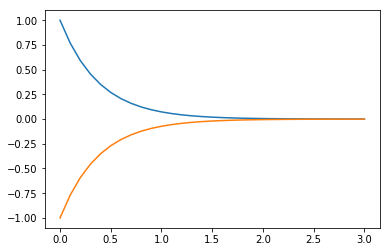

In [ ]:
h = 0.1; n = np.int(3/h)
Y = backEuler(y0,forceFun,AmatFun,h,n)

t = np.arange(0,n+1)*h
plt.plot(t,Y[0,:],t,Y[1,:]);

# Class assignment

We claimed that the backward Euler method is unconditionally stable. Demonstrate that by chaging $h$ and viewing the results.


# Homework assignment

Write a similar code to the backward Euler that uses the trapezoidal method.

Given the problem
$$ \dot y = A y \quad y(0) = y_0 $$
with 
$$ A = \begin{pmatrix} 0 & 1 \\ -1 & 0 \end{pmatrix} $$
and $y_0 = [0,1]$  test and compare the 3 methods for $h=10^{-j}, j=[1,2,3,4]$ when integrating
the system in the interval $t = [0,10]$
